# Income

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import textwrap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#DB CONNECTION

import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine,text
import getpass
from sklearn.preprocessing import normalize


In [ ]:
#db params
database = 'f24t03'
user = 'jsmm8'
password = getpass.getpass("Type password and hit enter: ")



Type password and hit enter: ········


In [ ]:
try:
    # Connect to the PostgreSQL database
    connection = psycopg2.connect(dbname=database, user=user, password=password, host='pgsql')
    cursor = connection.cursor()

    # Execute a query to get all table names
    cursor.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public';
    """)
    
    # Fetch all results
    tables = cursor.fetchall()

    # Print the table names
    print("Tables in the database:")
    for table in tables:
        print(table[0])

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

Tables in the database:
ethnicity
year_built
education_levels
tenure_by_bedrooms
tenure_by_kitchen
tenure_by_plumbing
education_data_processed
rooms
imputed_median_house_value
demographics_master
education_categories
income_pct_change
year_structure_built
mortgage
tenure_by_rooms
staging_race_data
race_data_processed
race_migration_data
housing_stats_data
merged_new_house_data
bedrooms
educational_attainment
employment_status
geo_mobility
home_value
house_heating_fuel
household_income
internet_subscription
income_to_poverty_ratio
median_home_value
median_household_income
median_rooms_by_tenure
occupancy_status
plumbing_facilities
poverty_status
income_data_processed
mortgage_status
housing_pct_change_stats_data


In [ ]:
#Create the connection and extract data from 'median_household_income' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the median_household_income table
query = "SELECT * FROM median_household_income where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    df = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df.shape

I am able to connect to the database
Data extracted successfully!


(15093, 8)

In [6]:
#check sample
df.head()

,geo_id,block_group,census_tract,county,state,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,56313.0,2840.0,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,57167.0,16907.0,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,48409.0,5803.0,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,34911.0,7714.0,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,54141.0,10685.0,2020


In [7]:
# Drop the moe_inflated_past_12_months_median_income column
df_cleaned = df.drop('moe_inflated_past_12_months_median_income',axis = 1)
#rename columns
df_cleaned.rename(columns={'est_inflated_past_12_months_median_income': 'median_income'}, inplace=True)
# Display the cleaned DataFrame
df_cleaned.head(1)

,geo_id,block_group,census_tract,county,state,median_income,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,56313.0,2020


In [8]:
#Check income stats
df_cleaned['median_income'].describe()

count        14317
unique       10563
top       250000.0
freq            54
Name: median_income, dtype: object

In [9]:
#Change datatype to float as we see this datatype as object
df_cleaned['median_income'] = df_cleaned['median_income'].astype(float)

In [10]:
#get unique years
years = df_cleaned['year'].unique()

# Get descriptive statistics for each year
for year in years:
    print(f"Descriptive statistics for {year}:")
    print(df_cleaned[df_cleaned['year'] == year].describe())
    print("\n")

Descriptive statistics for 2020:
       median_income    year
count    4775.000000  5031.0
mean    62207.912251  2020.0
std     31982.096050     0.0
min      2500.000000  2020.0
25%     41044.000000  2020.0
50%     55532.000000  2020.0
75%     75281.000000  2020.0
max    250000.000000  2020.0


Descriptive statistics for 2021:
       median_income    year
count    4772.000000  5031.0
mean    65670.566429  2021.0
std     33934.038780     0.0
min      2500.000000  2021.0
25%     43031.500000  2021.0
50%     58282.000000  2021.0
75%     79547.000000  2021.0
max    250000.000000  2021.0


Descriptive statistics for 2022:
       median_income    year
count    4770.000000  5031.0
mean    70985.040042  2022.0
std     35927.685373     0.0
min      2500.000000  2022.0
25%     46945.750000  2022.0
50%     63237.000000  2022.0
75%     86211.000000  2022.0
max    250000.000000  2022.0




In [11]:
#get counts of median value of income which falls into largest bracket of 250000+ in census datafile
df_cleaned[df_cleaned['median_income'] == 250000].groupby('year')['geo_id'].count()

year
2020    14
2021    19
2022    21
Name: geo_id, dtype: int64

In [12]:
# Filter for median_income equal to 250000
filtered_data = df_cleaned[df_cleaned['median_income'] == 250000]

# Group by year and aggregate geo_id counts, county names, and median income
income_counts = filtered_data.groupby('year').agg(
    geo_id_count=('geo_id', 'count'),
    counties=('county', lambda x: ', '.join(x.unique())),
    median_income=('median_income', 'median')  
).reset_index()

#Check data
income_counts


,year,geo_id_count,counties,median_income
0,2020,14,"Jackson County, St. Louis County",250000.0
1,2021,19,"Jackson County, St. Louis County",250000.0
2,2022,21,"Jackson County, St. Louis County",250000.0


* we see only Jackson County, St. Louis County has highest income brackets

In [13]:
# Filter for median_income equal to 2500 which falls into lowert bracket of 2500- in census datafile
filtered_data = df_cleaned[df_cleaned['median_income'] == 2500]

# Group by year and aggregate geo_id counts, county names, and median income
income_counts = filtered_data.groupby('year').agg(
    geo_id_count=('geo_id', 'count'),
    counties=('county', lambda x: ', '.join(x.unique())),
    median_income=('median_income', 'median')  
).reset_index()

#Check data
income_counts


,year,geo_id_count,counties,median_income
0,2020,1,Jackson County,2500.0
1,2021,1,Jackson County,2500.0
2,2022,4,"Jackson County, St. Louis city",2500.0


* we see only Jackson County, St. Louis City has lowest income brackets

In [14]:
# extract counties to filter for 250000+ limit bracket
counties_to_filter = ['Jackson County', 'St. Louis County']

# Filter the DataFrame for the specified counties
filtered_counties = df_cleaned[df_cleaned['county'].isin(counties_to_filter)]

# Calculate the median of median_income for each county and year
median_income_by_county_year = filtered_counties.groupby(['year', 'county'])['median_income'].median().reset_index()
#Check data
median_income_by_county_year


,year,county,median_income
0,2020,Jackson County,56768.0
1,2020,St. Louis County,71109.5
2,2021,Jackson County,60777.5
3,2021,St. Louis County,73750.0
4,2022,Jackson County,64063.0
5,2022,St. Louis County,78281.0


In [15]:
#counties to filter for 250000+ limit bracket
counties_to_filter = ['Jackson County', 'St. Louis County']

# Filter the DataFrame for the specified counties
filtered_counties = df_cleaned[df_cleaned['county'].isin(counties_to_filter)]

# Replace median_income of 250000 with 1000000
filtered_counties.loc[filtered_counties['median_income'] == 250000, 'median_income'] = 1000000 
# Calculate the median of median_income for each county and year
median_income_by_county_year = filtered_counties.groupby(['year', 'county'])['median_income'].median().reset_index()
#Check data
median_income_by_county_year

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,year,county,median_income
0,2020,Jackson County,56768.0
1,2020,St. Louis County,71109.5
2,2021,Jackson County,60777.5
3,2021,St. Louis County,73750.0
4,2022,Jackson County,64063.0
5,2022,St. Louis County,78281.0



* making the upper limit value to 1M has no impact on median values.


In [16]:
# counties to filter 2500- income bracket
counties_to_filter = ['Jackson County', 'St. Louis city']

# Filter the DataFrame for the specified counties
filtered_counties = df_cleaned[df_cleaned['county'].isin(counties_to_filter)]

# Replace median_income of 2500 with 10000
filtered_counties.loc[filtered_counties['median_income'] == 2500, 'median_income'] = 10000

# Calculate the median of median_income for each county and year
median_income_by_county_year = filtered_counties.groupby(['year', 'county'])['median_income'].median().reset_index()

#Check data
median_income_by_county_year


,year,county,median_income
0,2020,Jackson County,56768.0
1,2020,St. Louis city,47300.0
2,2021,Jackson County,60777.5
3,2021,St. Louis city,49681.0
4,2022,Jackson County,64063.0
5,2022,St. Louis city,55650.0



* Same case is observed with value 2500 as well when i tested with value 10000 and this does not drastically change median value.

In [17]:
#get null blockgroups each year
df_cleaned[df_cleaned['median_income'].isnull()].groupby('year').size()

year
2020    256
2021    259
2022    261
dtype: int64

In [18]:
#extract sample data from one year
df_cleaned[df_cleaned['year']==2022].head()

,geo_id,block_group,census_tract,county,state,median_income,year
10062,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,80208.0,2022
10063,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,64196.0,2022
10064,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,52438.0,2022
10065,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,46000.0,2022
10066,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,64063.0,2022


In [19]:
#convert to numeric
df_cleaned['median_income'] = pd.to_numeric(df_cleaned['median_income'], errors='raise')

In [20]:

# Group by year and county and calculate the median for each group
county_year_median = df_cleaned.groupby(['year', 'county']).median()

# Print the grouped median statistics for each year
for year in df_cleaned['year'].unique():
    print(f"Median statistics for each county in {year}:")
    print(county_year_median.loc[year])  
    print("\n")


Median statistics for each county in 2020:
                   median_income
county                          
Adair County             40046.0
Andrew County            58970.0
Atchison County          51250.0
Audrain County           43452.0
Barry County             49011.0
...                          ...
Washington County        42500.0
Wayne County             36250.0
Webster County           51267.5
Worth County             43056.0
Wright County            36397.5

[115 rows x 1 columns]


Median statistics for each county in 2021:
                   median_income
county                          
Adair County             50781.0
Andrew County            67511.0
Atchison County          52813.0
Audrain County           45180.5
Barry County             53326.5
...                          ...
Washington County        44489.0
Wayne County             39904.0
Webster County           59282.5
Worth County             41513.0
Wright County            41902.5

[115 rows x 1 columns]


Medi

<Figure size 1008x576 with 0 Axes>

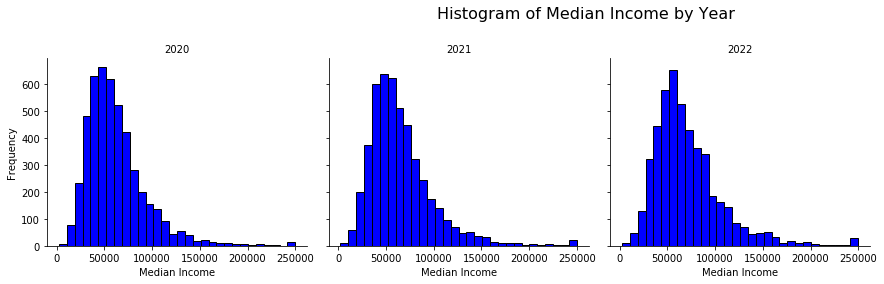

In [21]:
# Create a facet grid with histograms
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(df_cleaned, col='year', col_wrap=4, height=4)
g.map(plt.hist, 'median_income', bins=30, color='blue', edgecolor='black')

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Median Income', 'Frequency')
g.fig.suptitle('Histogram of Median Income by Year', fontsize=16)
g.fig.subplots_adjust(top=0.8)  

plt.show()


* We see positive skew for the median income values and it is expected.

In [22]:
#get info
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15093 entries, 0 to 15092
Data columns (total 7 columns):
geo_id           15093 non-null object
block_group      15093 non-null object
census_tract     15093 non-null object
county           15093 non-null object
state            15093 non-null object
median_income    14317 non-null float64
year             15093 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 825.5+ KB


In [23]:
#create pivot table to get year-wise missing data in block groups(Same blockgroup is missing in any year will be extracted)
pivot_table = df_cleaned.pivot_table(index='geo_id', columns='year', values='median_income', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']
#check counts
print(counts)

   Number of Missing Years  Geography Count
0                        0             4520
1                        1              322
2                        2              113
3                        3               76


In [ ]:
#Create the connection and extract data from 'race_data_processed' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the race_data_processed table
query = "SELECT * FROM race_data_processed where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    df_race_ethnic_data = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df_race_ethnic_data.shape

I am able to connect to the database
Data extracted successfully!


(15093, 22)

In [25]:
#get sample
df_race_ethnic_data.head()

,geo_id,total_population,shannon_index,simpsons_index,richness,simpson_dominance,berger_parker_dominance,simpson_evenness,year,block_group,...,state,group_classification,hispanic_or_latino,asian,black,native,other,pac_isl,two_or_more_races,white
0,1500000US290019501001,1121,0.079,0.044,0.500,0.956,0.978,0.059,2022,Block Group 1,...,Missouri,white Dominant with low diversity,0.005,0.000,0.000,0.000,0.005,0.000,0.013,1.000
1,1500000US290019501002,1589,0.059,0.034,0.375,0.966,0.983,0.050,2022,Block Group 2,...,Missouri,white Dominant with low diversity,0.000,0.004,0.000,0.000,0.000,0.000,0.013,1.000
2,1500000US290019501003,961,0.271,0.245,0.625,0.755,0.858,0.306,2022,Block Group 3,...,Missouri,white Dominant with high diversity,0.154,0.000,0.001,0.004,0.000,0.000,0.004,0.988
3,1500000US290019502001,1031,0.287,0.200,0.625,0.800,0.892,0.250,2022,Block Group 1,...,Missouri,white Dominant with high diversity,0.062,0.014,0.000,0.000,0.000,0.014,0.030,0.997
4,1500000US290019502002,998,0.057,0.037,0.250,0.963,0.981,0.075,2022,Block Group 2,...,Missouri,white Dominant with low diversity,0.000,0.000,0.000,0.000,0.000,0.000,0.019,1.000


In [26]:
#get zero population records
df_zero_population = df_race_ethnic_data[df_race_ethnic_data['total_population'] == 0]

# Display the resulting DataFrame
yearwise_count = df_zero_population.groupby('year').size().reset_index(name='Count')

# Display the year-wise count DataFrame
print(yearwise_count)

   year  Count
0  2020     17
1  2021     18
2  2022     19


In [27]:
# Filter DataFrames for each year
df_2020 = df_zero_population[df_zero_population['year'] == 2020]
df_2021 = df_zero_population[df_zero_population['year'] == 2021]
df_2022 = df_zero_population[df_zero_population['year'] == 2022]


# Find common geographies across the three years
common_geographies = set(df_2020['geo_id']).intersection(df_2021['geo_id'], df_2022['geo_id'])

# Extract counts for common geographies
common_counts = df_zero_population[df_zero_population['geo_id'].isin(common_geographies)]

# Group by Geography and Year to get counts
final_counts = common_counts.groupby(['geo_id', 'year']).size().reset_index(name='Count')




In [28]:
#get median
median_income_per_year = df_cleaned.groupby('year')['median_income'].median().reset_index()

#rename columns
median_income_per_year.columns = ['year', 'Median Income']

#Identify geographies with missing values in all three years

geographies_with_3_missing = pivot_table[pivot_table['Missing Values Count'] == 3].index

#Get the geographies from df_zero_population
geographies_zero_population = common_geographies

#Update median_income for those geographies where it is missing
for geo in geographies_with_3_missing:
    for year in df_cleaned['year'].unique():
        if geo in geographies_zero_population:
            # Set median_income to 0 for the identified geography and year
            df_cleaned.loc[(df_cleaned['geo_id'] == geo) & (df_cleaned['year'] == year), 'median_income'] = 0



In [29]:
#create pivot table to get year-wise missing data in block groups(Same blockgroup is missing in any year will be extracted)
pivot_table = df_cleaned.pivot_table(index='geo_id', columns='year', values='median_income', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']

print(counts)

   Number of Missing Years  Geography Count
0                        0             4537
1                        1              322
2                        2              113
3                        3               59


In [ ]:
#Create the connection and extract data from 'occupancy_status' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the occupancy_status table
query = "SELECT * FROM occupancy_status where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    merged_housing_data = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
merged_housing_data.shape

I am able to connect to the database
Data extracted successfully!


(15093, 12)

In [31]:
# Display the merged DataFrame
merged_housing_data.head()


,geo_id,block_group,census_tract,county,state,total_estimate,total_margin_of_error,est_total_occupied,moe_total_occupied,est_total_vacant,margin_of_error_total_vacant,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,581,86,448,79,133,69,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,607,86,516,91,91,47,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,499,70,338,58,161,47,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,421,71,315,57,106,52,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,547,92,377,79,170,48,2020


In [32]:
# select columns to drop
columns_to_drop = ['total_margin_of_error','moe_total_occupied','margin_of_error_total_vacant']


# Drop the identified columns
merged_housing_data = merged_housing_data.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print("\nCleaned DataFrame:")
merged_housing_data.head(1)


Cleaned DataFrame:


,geo_id,block_group,census_tract,county,state,total_estimate,est_total_occupied,est_total_vacant,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,581,448,133,2020


In [33]:
# Filter DataFrames for each year based on 'Total' column
df_housing_2020 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2020)]
df_housing_2021 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2021)]
df_housing_2022 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2022)]

# Find common geographies across the three years
common_geographies = set(df_housing_2020['geo_id']).intersection(df_housing_2021['geo_id'], df_housing_2022['geo_id'])

# Extract counts for common geographies
common_counts = pd.concat([
    df_housing_2020[df_housing_2020['geo_id'].isin(common_geographies)],
    df_housing_2021[df_housing_2021['geo_id'].isin(common_geographies)],
    df_housing_2022[df_housing_2022['geo_id'].isin(common_geographies)]

])

# Group by Geography and Year to get counts
final_counts = common_counts.groupby(['geo_id']).size().reset_index(name='Count')



In [34]:
#extract geo_ids which have missing data in all 3 years 2020,2021 and 2022
geographies_with_3_missing = pivot_table[pivot_table['Missing Values Count'] == 3].index

#Get the geographies from df_zero_population
geographies_zero_housing = common_geographies

## Update median_income for those geographies where it is missing
for geo in geographies_with_3_missing:
    for year in df_cleaned['year'].unique():
        if geo in geographies_zero_housing:
            # Set median_income to 0 for the identified geography and year
            df_cleaned.loc[(df_cleaned['geo_id'] == geo) & (df_cleaned['year'] == year), 'median_income'] = 0

In [35]:
#create pivot table to get year-wise missing data in block groups(Same blockgroup is missing in any year will be extracted)
pivot_table = df_cleaned.pivot_table(index='geo_id', columns='year', values='median_income', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']

print(counts)

   Number of Missing Years  Geography Count
0                        0             4540
1                        1              322
2                        2              113
3                        3               56


In [36]:
# Filter for rows with NULL or empty values in median_income
null_income_df = df_cleaned[df_cleaned['median_income'].isnull() | 
                              (df_cleaned['median_income'] == '')]

# Select the relevant columns
df_missing = null_income_df[['geo_id', 'median_income', 'year']]


/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [37]:
# Filter rows where 'median_income' is  NULL
missing_or_zero = df_cleaned[(df_cleaned['median_income'].isnull())]

# Group by 'year' and count the occurrences
yearwise_count = missing_or_zero.groupby('year').size().reset_index(name='Count')

# Display the year-wise count

yearwise_count


,year,Count
0,2020,236
1,2021,239
2,2022,241


In [ ]:
#Create the connection and extract data from 'household_income' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the household_income table
query = "SELECT * FROM household_income where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    df = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df.shape

I am able to connect to the database
Data extracted successfully!


(15093, 40)

In [39]:
#check sample
df.head()

,geo_id,block_group,census_tract,county,state,est_total,moe_total,est_less_than_10k,moe_less_than_10k,est_10to15k,...,moe_75to100k,est_100to125k,moe_100to125k,est_125to150k,moe_125to150k,est_150to200k,moe_150to200k,est_more_than_200k,moe_more_than_200k,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,448,79,0,12,10,...,32,47,29,22,21,7,10,5,8,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,516,91,7,8,99,...,43,44,37,21,18,40,36,3,5,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,338,58,13,14,24,...,21,9,9,15,16,14,11,9,9,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,315,57,36,22,44,...,23,24,25,0,12,0,12,3,5,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,377,79,20,24,43,...,26,27,20,18,23,35,45,12,11,2020


In [40]:
#get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15093 entries, 0 to 15092
Data columns (total 40 columns):
geo_id                15093 non-null object
block_group           15093 non-null object
census_tract          15093 non-null object
county                15093 non-null object
state                 15093 non-null object
est_total             15093 non-null int64
moe_total             15093 non-null int64
est_less_than_10k     15093 non-null int64
moe_less_than_10k     15093 non-null int64
est_10to15k           15093 non-null int64
moe_10to15k           15093 non-null int64
est_15to20k           15093 non-null int64
moe_15to20k           15093 non-null int64
est_20to25k           15093 non-null int64
moe_20to25k           15093 non-null int64
est_25to30k           15093 non-null int64
moe_25to30k           15093 non-null int64
est_30to35k           15093 non-null int64
moe_30to35k           15093 non-null int64
est_35to40k           15093 non-null int64
moe_35to40k           1509

In [41]:
# Mapping column names to income ranges and use the method of creating samples out of income distribution data and
#create sample random records and then generate the median

income_brackets = {
    'est_less_than_10k': (0, 9999),
    'est_10to15k': (10000, 14999),
    'est_15to20k': (15000, 19999),
    'est_20to25k': (20000, 24999),
    'est_25to30k': (25000, 29999),
    'est_30to35k': (30000, 34999),
    'est_35to40k': (35000, 39999),
    'est_40to45k': (40000, 44999),
    'est_45to50k': (45000, 49999),
    'est_50to60k': (50000, 59999),
    'est_60to75k': (60000, 74999),
    'est_75to100k': (75000, 99999),
    'est_100to125k': (100000, 124999),
    'est_125to150k': (125000, 149999),
    'est_150to200k': (150000, 199999),
    'est_more_than_200k': (200000, 1000000)  # Creating 1M as an upper bound for estimates above 200k as we have median as 250k+ in dataset which falls under highest income bracket
}

# Initialize a list to store results
all_results = []
np.random.seed(0)
# Iterate over rows in df
for index, row in df.iterrows():
    # Extract the year from the row
    year = row['year']
    
    # Generate synthetic income records for each geography
    synthetic_records = []
    
    for col, (min_income, max_income) in income_brackets.items():
        num_samples = row[col]
        
        if num_samples > 0:  # Only generate samples if there are estimates
            samples = np.random.randint(
                min_income, 
                max_income + 1, 
                size=num_samples
            ) 
            synthetic_records.extend(samples)
    
    # Calculate the median for the current geography
    median_income = np.median(synthetic_records) if synthetic_records else None
    
    # Store the geography, median income, and year
    all_results.append({
        'geo_id': row['geo_id'],
        'Median Income': median_income,
        'year': year
    })

# Create a DataFrame for all results
results_df = pd.DataFrame(all_results)

# Check for zero or null values in the 'Median Income' column
zero_values = results_df[results_df['Median Income'] == 0]
null_values = results_df[results_df['Median Income'].isnull()]

results_df['Median Income'] = results_df['Median Income'].round(0)
# Display the results DataFrame
results_df.head()
#create backup data
imputed_data = results_df

In [42]:
# Filter rows where 'median_income' is either NULL or 0
missing_or_zero = results_df[(results_df['Median Income'].isnull()) | (results_df['Median Income'] == 0)]

# Group by 'year' and count the occurrences
yearwise_count = missing_or_zero.groupby('year').size().reset_index(name='Count')

# Display the year-wise count
print("Year-wise Count of (geo_id, year) Combinations with NULL or 0 Median Income:\n")
yearwise_count


Year-wise Count of (geo_id, year) Combinations with NULL or 0 Median Income:



,year,Count
0,2020,20
1,2021,21
2,2022,22


In [43]:
# Merge 'df_cleaned' with 'results_df' on 'geo_id' and 'year' to fetch 'Median Income'
df_filled = df_cleaned.merge(
    results_df[['geo_id', 'year', 'Median Income']],
    on=['geo_id', 'year'],
    how='left'
)

# Impute NULL values in 'median_income' with corresponding 'Median Income' from 'results_df'
df_filled['median_income'] = df_filled['median_income'].fillna(df_filled['Median Income'])

# Drop the temporary 'Median Income' column as it's no longer needed
df_filled = df_filled.drop(columns=['Median Income'])

# Display the updated DataFrame

df_filled.head()

,geo_id,block_group,census_tract,county,state,median_income,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,56313.0,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,57167.0,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,48409.0,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,34911.0,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,54141.0,2020


In [44]:
#check final shape
df_filled.shape

(15093, 7)

In [45]:
#create pivot table to get year-wise missing data in block groups(Same blockgroup is missing in any year will be extracted)
pivot_table = df_filled.pivot_table(index='geo_id', columns='year', values='median_income', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']

print(counts)

   Number of Missing Years  Geography Count
0                        0             5029
1                        2                1
2                        1                1


In [46]:
# Create a pivot table to inspect missing values across years for each geo_id
pivot_table = df_filled.pivot_table(
    index='geo_id', columns='year', values='median_income', 
    aggfunc=lambda x: x.isnull().sum(), fill_value=0
)

# Count the number of missing values across years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies with missing values (i.e., Missing Values Count > 0)
geos_with_missing = pivot_table[pivot_table['Missing Values Count'] > 0].reset_index()

print("Geographies with Remaining Missing Values:\n")
print(geos_with_missing)

# Display specific (geo_id, year) combinations with NULL median_income
remaining_nulls = df_filled[df_filled['median_income'].isnull()]
print("\nSpecific (geo_id, year) Combinations with NULL median_income:\n")
remaining_nulls[['geo_id', 'year', 'median_income']]

# Fill the remaining NULL median_income values with 0
df_filled['median_income'] = df_filled['median_income'].fillna(0)

# Verify that there are no more NULL values
remaining_nulls_after = df_filled[df_filled['median_income'].isnull()]

print("\nRemaining NULL Values After Filling with 0 (should be empty):\n")
print(remaining_nulls_after)


Geographies with Remaining Missing Values:

year                 geo_id  2020  2021  2022  Missing Values Count
0     1500000US290770006004     0     1     1                     2
1     1500000US291839800001     0     0     1                     1

Specific (geo_id, year) Combinations with NULL median_income:


Remaining NULL Values After Filling with 0 (should be empty):

Empty DataFrame
Columns: [geo_id, block_group, census_tract, county, state, median_income, year]
Index: []


We dont see any missing values now as we imputed the data wherever it is applicable.

In [47]:
#create pivot table to get year-wise missing data in block groups(Same blockgroup is missing in any year will be extracted)
pivot_table = df_filled.pivot_table(index='geo_id', columns='year', values='median_income', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']

#verify the counts again
print(counts)

   Number of Missing Years  Geography Count
0                        0             5031


In [48]:
#As all missing data is imputed , lets check final info
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093 entries, 0 to 15092
Data columns (total 7 columns):
geo_id           15093 non-null object
block_group      15093 non-null object
census_tract     15093 non-null object
county           15093 non-null object
state            15093 non-null object
median_income    15093 non-null float64
year             15093 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 943.3+ KB


In [49]:
#Check info of income brackets dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15093 entries, 0 to 15092
Data columns (total 40 columns):
geo_id                15093 non-null object
block_group           15093 non-null object
census_tract          15093 non-null object
county                15093 non-null object
state                 15093 non-null object
est_total             15093 non-null int64
moe_total             15093 non-null int64
est_less_than_10k     15093 non-null int64
moe_less_than_10k     15093 non-null int64
est_10to15k           15093 non-null int64
moe_10to15k           15093 non-null int64
est_15to20k           15093 non-null int64
moe_15to20k           15093 non-null int64
est_20to25k           15093 non-null int64
moe_20to25k           15093 non-null int64
est_25to30k           15093 non-null int64
moe_25to30k           15093 non-null int64
est_30to35k           15093 non-null int64
moe_30to35k           15093 non-null int64
est_35to40k           15093 non-null int64
moe_35to40k           1509

In [50]:
#Merge all income related data
df_filtered = df[df['year'].isin([2020, 2021, 2022])]

# Perform an inner join with df_filled on 'geo_id' and 'year'
merged_df = pd.merge(df_filled, df_filtered, on=['geo_id', 'year'], how='inner')

# Display the shape and the first few rows of the merged DataFrame
print("Merged DataFrame shape:", merged_df.shape)
merged_df.head()

Merged DataFrame shape: (15093, 45)


,geo_id,block_group_x,census_tract_x,county_x,state_x,median_income,year,block_group_y,census_tract_y,county_y,...,est_75to100k,moe_75to100k,est_100to125k,moe_100to125k,est_125to150k,moe_125to150k,est_150to200k,moe_150to200k,est_more_than_200k,moe_more_than_200k
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,56313.0,2020,Block Group 1,Census Tract 9501,Adair County,...,59,32,47,29,22,21,7,10,5,8
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,57167.0,2020,Block Group 2,Census Tract 9501,Adair County,...,68,43,44,37,21,18,40,36,3,5
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,48409.0,2020,Block Group 3,Census Tract 9501,Adair County,...,37,21,9,9,15,16,14,11,9,9
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,34911.0,2020,Block Group 1,Census Tract 9502,Adair County,...,55,23,24,25,0,12,0,12,3,5
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,54141.0,2020,Block Group 2,Census Tract 9502,Adair County,...,40,26,27,20,18,23,35,45,12,11


In [51]:
# Drop all columns that start with 'moe_' + total
columns_to_drop = [col for col in merged_df.columns if col.startswith('moe_')]+ ['est_total']
merged_df = merged_df.drop(columns=columns_to_drop)

# Drop duplicated columns and rename remaining columns to original names
# Keep the columns with the '_y' suffix and rename them to remove the suffix
columns_to_rename = {
    'block_group_y': 'block_group',
    'census_tract_y': 'census_tract',
    'county_y': 'county',
    'state_y': 'state'
}

# Drop the '_x' columns and rename '_y' columns
merged_df = merged_df.rename(columns=columns_to_rename)
merged_df = merged_df.drop(columns=[col for col in merged_df.columns if col.endswith('_x')])



In [52]:
#Check dataframe structre again
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093 entries, 0 to 15092
Data columns (total 23 columns):
geo_id                15093 non-null object
median_income         15093 non-null float64
year                  15093 non-null int64
block_group           15093 non-null object
census_tract          15093 non-null object
county                15093 non-null object
state                 15093 non-null object
est_less_than_10k     15093 non-null int64
est_10to15k           15093 non-null int64
est_15to20k           15093 non-null int64
est_20to25k           15093 non-null int64
est_25to30k           15093 non-null int64
est_30to35k           15093 non-null int64
est_35to40k           15093 non-null int64
est_40to45k           15093 non-null int64
est_45to50k           15093 non-null int64
est_50to60k           15093 non-null int64
est_60to75k           15093 non-null int64
est_75to100k          15093 non-null int64
est_100to125k         15093 non-null int64
est_125to150k         15

In [53]:
#Approach: This method calculates the area under the Lorenz curve. It takes cumulative shares of population and income to plot a curve, then integrates to find the area under the curve.
# This calculation requires both cumulative population and income shares, making it suitable for income inequality where each value represents an income level for a share of the population.
# It gives the Gini coefficient based on the Lorenz curve, which is a common approach for income distributions.
#(Lorenz curve-based) is best for continuous distributions like income, where we have both population and income shares.

# Define the income bracket columns from DataFrame
income_bracket_columns = [
    'est_less_than_10k',
    'est_10to15k',
    'est_15to20k',
    'est_20to25k',
    'est_25to30k',
    'est_30to35k',
    'est_35to40k',
    'est_40to45k',
    'est_45to50k',
    'est_50to60k',
    'est_60to75k',
    'est_75to100k',
    'est_100to125k',
    'est_125to150k',
    'est_150to200k',
    'est_more_than_200k'
]

# Initialize a list to store Gini results
gini_results = []

# Grouping by geo_id and year to compute Gini for each group
for (geo_id, year), group in merged_df.groupby(['geo_id', 'year']):
    # Get counts of individuals in income brackets
    counts = group[income_bracket_columns].values.flatten()  # Flatten to a 1D array
    total_individuals = counts.sum()
    
    # If there are no individuals, Gini is undefined (set to NaN or 0)
    if total_individuals == 0:
        gini_results.append({'geo_id': geo_id, 'year': year, 'gini_coefficient': None})
        continue

    # Calculate cumulative shares for Gini calculation
    # Sort counts and calculate cumulative distributions
    sorted_counts = np.sort(counts)
    cumulative_counts = np.cumsum(sorted_counts)
    
    # Cumulative share of population
    cumulative_share_population = cumulative_counts / total_individuals
    
    # For income values, assuming midpoint of income brackets:
    income_values = [
        5000,   
        12500,  
        17500,  
        22500,  
        27500,  
        32500,  
        37500,  
        42500,  
        47500,  
        55000,  
        67500,  
        87500,  
        112500, 
        137500, 
        175000, 
        500000  
    ]
    
    # Calculate cumulative income
    cumulative_income = np.cumsum(sorted_counts * income_values)
    cumulative_share_income = cumulative_income / cumulative_income[-1] if cumulative_income[-1] != 0 else 0
    
    # Calculate area under the Lorenz curve
    A = np.trapz(cumulative_share_income, cumulative_share_population)
    
    # Gini coefficient is calculated as: 1 - 2*A
    gini_coefficient = 1 - 2 * A
    
    # Append results
    gini_results.append({'geo_id': geo_id, 'year': year, 'gini_coefficient': gini_coefficient})

# Create a DataFrame from the Gini results
gini_df = pd.DataFrame(gini_results)

# Display the results
gini_df['gini_coefficient'] = gini_df['gini_coefficient']

#The money income Gini index decreased by 1.2 percent between 2021 and 2022 (from 0.494 to 0.488); this represents the first time the Gini index has shown an annual decrease since 2007 (Figure 3 and Table A-3).

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.17757774e-02, 0.00000000e+00, 0.00000000e+00, 7.25859248e-03,
        9.67812330e-03, 2.41953083e-02, 2.17757774e-02, 7.25859248e-02,
        1.01620295e-01, 1.76625750e-01, 2.63728860e-01, 5.61331152e-01,
        1.10572559e+00, 2.41953083e+00, 4.86083743e+00, 7.96025642e+00,
        9.49423896e+00, 6.95131206e+00, 2.19209493e+00, 1.20976541e-01]),
 array([0.        , 0.02749855, 0.05499711, 0.08249566, 0.10999422,
        0.13749277, 0.16499132, 0.19248988, 0.21998843, 0.24748699,
        0.27498554, 0.3024841 , 0.32998265, 0.3574812 , 0.38497976,
        0.41247831, 0.43997687, 0.46747542, 0.49497397, 0.52247253,
        0.54997108]),
 <a list of 20 Patch objects>)

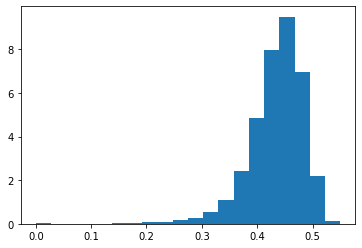

In [54]:
#plot gini
plt.hist(gini_df['gini_coefficient'], density=True, bins=20)

In [55]:
# Merge the Gini coefficients back into the merged_df
merged_df = merged_df.merge(gini_df, on=['geo_id', 'year'], how='left')
merged_df['gini_coefficient'] = merged_df['gini_coefficient'].round(2)
# Display the updated merged_df
merged_df.head()

,geo_id,median_income,year,block_group,census_tract,county,state,est_less_than_10k,est_10to15k,est_15to20k,...,est_40to45k,est_45to50k,est_50to60k,est_60to75k,est_75to100k,est_100to125k,est_125to150k,est_150to200k,est_more_than_200k,gini_coefficient
0,1500000US290019501001,56313.0,2020,Block Group 1,Census Tract 9501,Adair County,Missouri,0,10,19,...,29,16,107,36,59,47,22,7,5,0.48
1,1500000US290019501002,57167.0,2020,Block Group 2,Census Tract 9501,Adair County,Missouri,7,99,6,...,27,15,43,78,68,44,21,40,3,0.47
2,1500000US290019501003,48409.0,2020,Block Group 3,Census Tract 9501,Adair County,Missouri,13,24,8,...,9,30,41,37,37,9,15,14,9,0.50
3,1500000US290019502001,34911.0,2020,Block Group 1,Census Tract 9502,Adair County,Missouri,36,44,16,...,7,12,13,23,55,24,0,0,3,0.47
4,1500000US290019502002,54141.0,2020,Block Group 2,Census Tract 9502,Adair County,Missouri,20,43,17,...,19,4,44,37,40,27,18,35,12,0.50


In [56]:
#normalize raw counts

# List of brackets
income_brackets = [
    'est_less_than_10k',
    'est_10to15k',
    'est_15to20k',
    'est_20to25k',
    'est_25to30k',
    'est_30to35k',
    'est_35to40k',
    'est_40to45k',
    'est_45to50k',
    'est_50to60k',
    'est_60to75k',
    'est_75to100k',
    'est_100to125k',
    'est_125to150k',
    'est_150to200k',
    'est_more_than_200k'
]


# Extract race-related data
inc_subset_data = merged_df[income_brackets]

# Apply row-wise normalization (L2 normalization)
normalized_inc_data = pd.DataFrame(normalize(inc_subset_data, norm='l2', axis=1), 
                                   columns=income_brackets)

normalized_inc_data = normalized_inc_data.round(2)

# Join the normalized race data back to the original dataframe
df_normalized = merged_df.drop(columns=income_brackets).join(normalized_inc_data)

# Now df_normalized has normalized race data per row
df_normalized.head()


,geo_id,median_income,year,block_group,census_tract,county,state,gini_coefficient,est_less_than_10k,est_10to15k,...,est_35to40k,est_40to45k,est_45to50k,est_50to60k,est_60to75k,est_75to100k,est_100to125k,est_125to150k,est_150to200k,est_more_than_200k
0,1500000US290019501001,56313.0,2020,Block Group 1,Census Tract 9501,Adair County,Missouri,0.48,0.00,0.07,...,0.14,0.19,0.11,0.70,0.24,0.39,0.31,0.14,0.05,0.03
1,1500000US290019501002,57167.0,2020,Block Group 2,Census Tract 9501,Adair County,Missouri,0.47,0.04,0.59,...,0.04,0.16,0.09,0.25,0.46,0.40,0.26,0.12,0.24,0.02
2,1500000US290019501003,48409.0,2020,Block Group 3,Census Tract 9501,Adair County,Missouri,0.50,0.13,0.25,...,0.10,0.09,0.31,0.43,0.38,0.38,0.09,0.16,0.15,0.09
3,1500000US290019502001,34911.0,2020,Block Group 1,Census Tract 9502,Adair County,Missouri,0.47,0.36,0.44,...,0.20,0.07,0.12,0.13,0.23,0.55,0.24,0.00,0.00,0.03
4,1500000US290019502002,54141.0,2020,Block Group 2,Census Tract 9502,Adair County,Missouri,0.50,0.19,0.40,...,0.14,0.18,0.04,0.41,0.35,0.38,0.25,0.17,0.33,0.11


In [57]:
#drop the moe_ columns 
df_normalized = df_normalized.drop(columns=df_normalized.filter(like='moe_').columns)
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093 entries, 0 to 15092
Data columns (total 24 columns):
geo_id                15093 non-null object
median_income         15093 non-null float64
year                  15093 non-null int64
block_group           15093 non-null object
census_tract          15093 non-null object
county                15093 non-null object
state                 15093 non-null object
gini_coefficient      15030 non-null float64
est_less_than_10k     15093 non-null float64
est_10to15k           15093 non-null float64
est_15to20k           15093 non-null float64
est_20to25k           15093 non-null float64
est_25to30k           15093 non-null float64
est_30to35k           15093 non-null float64
est_35to40k           15093 non-null float64
est_40to45k           15093 non-null float64
est_45to50k           15093 non-null float64
est_50to60k           15093 non-null float64
est_60to75k           15093 non-null float64
est_75to100k          15093 non-null float6

In [58]:
# Filter the DataFrame for median_income of 250000
filtered_df = df_normalized[df_normalized['median_income'] == 250000]

# Select the geo_id and year columns
geo_year_combinations = filtered_df[['geo_id', 'year']]

# Display the resulting DataFrame
geo_year_combinations


,geo_id,year
1687,1500000US290950084001,2020
3946,1500000US291892152341,2020
3959,1500000US291892154001,2020
3960,1500000US291892154002,2020
3962,1500000US291892154004,2020
3963,1500000US291892154005,2020
3994,1500000US291892161011,2020
4005,1500000US291892162023,2020
4007,1500000US291892163001,2020
4055,1500000US291892177012,2020


In [59]:
# Create a list of tuples for geo_id and year combinations
geo_year_tuples = list(zip(geo_year_combinations['geo_id'], geo_year_combinations['year']))

# Filter the imputed_data for the specified geo_id and year combinations
filtered_imputed_data = imputed_data[
    imputed_data.set_index(['geo_id', 'year']).index.isin(geo_year_tuples)
]

# Select the relevant columns
result = filtered_imputed_data[['geo_id', 'year', 'Median Income']]

# Display the resulting DataFrame
result


,geo_id,year,Median Income
1687,1500000US290950084001,2020,349834.0
3946,1500000US291892152341,2020,421047.0
3959,1500000US291892154001,2020,401302.0
3960,1500000US291892154002,2020,370808.0
3962,1500000US291892154004,2020,436690.0
3963,1500000US291892154005,2020,241247.0
3994,1500000US291892161011,2020,282846.0
4005,1500000US291892162023,2020,228656.0
4007,1500000US291892163001,2020,544450.0
4055,1500000US291892177012,2020,217522.0


In [60]:
# Iterate through the result DataFrame to update df_normalized
for index, row in result.iterrows():
    geo_id = row['geo_id']
    year = row['year']
    median_income_value = row['Median Income']
    
    # Update df_normalized where geo_id and year match
    df_normalized.loc[
        (df_normalized['geo_id'] == geo_id) & (df_normalized['year'] == year), 
        'median_income'
    ] = median_income_value

#check final shape
print(df_normalized[df_normalized['median_income'] == 250000].shape)


(0, 24)


In [61]:
# Filter the DataFrame for median_income of 2500
filtered_df = df_normalized[df_normalized['median_income'] == 2500]

# Select the geo_id and year columns
geo_year_combinations = filtered_df[['geo_id', 'year']]

# Display the resulting DataFrame
geo_year_combinations


,geo_id,year
2100,1500000US290950154012,2020
7131,1500000US290950154012,2021
11979,1500000US290950134051,2022
12162,1500000US290950154012,2022
14865,1500000US295101067001,2022
14912,1500000US295101111002,2022


In [62]:
# Create a list of tuples for geo_id and year combinations
geo_year_tuples = list(zip(geo_year_combinations['geo_id'], geo_year_combinations['year']))

# Filter the imputed_data for the specified geo_id and year combinations
filtered_imputed_data = imputed_data[
    imputed_data.set_index(['geo_id', 'year']).index.isin(geo_year_tuples)
]

# Select the relevant columns
result = filtered_imputed_data[['geo_id', 'year', 'Median Income']]

# Display the resulting DataFrame
result


,geo_id,year,Median Income
2100,1500000US290950154012,2020,6786.0
7131,1500000US290950154012,2021,6746.0
11979,1500000US290950134051,2022,8557.0
12162,1500000US290950154012,2022,5931.0
14865,1500000US295101067001,2022,8077.0
14912,1500000US295101111002,2022,8530.0


In [63]:
# Iterate through the result DataFrame to update df_normalized
for index, row in result.iterrows():
    geo_id = row['geo_id']
    year = row['year']
    median_income_value = row['Median Income']
    
    # Update df_normalized where geo_id and year match
    df_normalized.loc[
        (df_normalized['geo_id'] == geo_id) & (df_normalized['year'] == year), 
        'median_income'
    ] = median_income_value

# check shape
print(df_normalized[df_normalized['median_income'] == 2500].shape)


(0, 24)


In [64]:
# Replace NaN values in the 'gini_coefficient' column with -1
df_normalized['gini_coefficient'] = df_normalized['gini_coefficient'].fillna(-1)

In [65]:
#get info
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093 entries, 0 to 15092
Data columns (total 24 columns):
geo_id                15093 non-null object
median_income         15093 non-null float64
year                  15093 non-null int64
block_group           15093 non-null object
census_tract          15093 non-null object
county                15093 non-null object
state                 15093 non-null object
gini_coefficient      15093 non-null float64
est_less_than_10k     15093 non-null float64
est_10to15k           15093 non-null float64
est_15to20k           15093 non-null float64
est_20to25k           15093 non-null float64
est_25to30k           15093 non-null float64
est_30to35k           15093 non-null float64
est_35to40k           15093 non-null float64
est_40to45k           15093 non-null float64
est_45to50k           15093 non-null float64
est_50to60k           15093 non-null float64
est_60to75k           15093 non-null float64
est_75to100k          15093 non-null float6

In [ ]:
#Create Table income_data_processed

mypasswd = getpass.getpass("Enter your database password: ")

# Database connection details
database = "f24t03"
user = "ypd5yb"
password = mypasswd
host = "pgsql"

# Create a connection to the database using SQLAlchemy 
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}/{database}')


# Connect and create/drop the table, then insert data in chunks
try:
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, host=host, password=password)
    cursor = conn.cursor()
    print("Connected to the database.")

    # Drop the ethnicity table if it exists
    cursor.execute("DROP TABLE IF EXISTS income_data_processed;")
    print("Dropped the income_data_processed table if it existed.")

    # Create the ethnicity table
    create_table_query = """
CREATE TABLE income_data_processed (
    geo_id TEXT NOT NULL,
    median_income FLOAT8 NOT NULL,
    year INT NOT NULL,
    block_group TEXT NOT NULL,
    census_tract TEXT NOT NULL,
    county TEXT NOT NULL,
    state TEXT NOT NULL,
    gini_coefficient FLOAT8 NOT NULL,
    est_less_than_10k FLOAT8 NOT NULL,
    est_10to15k FLOAT8 NOT NULL,
    est_15to20k FLOAT8 NOT NULL,
    est_20to25k FLOAT8 NOT NULL,
    est_25to30k FLOAT8 NOT NULL,
    est_30to35k FLOAT8 NOT NULL,
    est_35to40k FLOAT8 NOT NULL,
    est_40to45k FLOAT8 NOT NULL,
    est_45to50k FLOAT8 NOT NULL,
    est_50to60k FLOAT8 NOT NULL,
    est_60to75k FLOAT8 NOT NULL,
    est_75to100k FLOAT8 NOT NULL,
    est_100to125k FLOAT8 NOT NULL,
    est_125to150k FLOAT8 NOT NULL,
    est_150to200k FLOAT8 NOT NULL,
    est_more_than_200k FLOAT8 NOT NULL,
    PRIMARY KEY (geo_id, year)
);
    """
    cursor.execute(create_table_query)
    conn.commit()
    print("Created the income_data_processed table.")

    # Insert data from df_normalized in chunks
    chunk_size = 500
    for start in range(0, len(df_normalized), chunk_size):
        chunk = df_normalized.iloc[start:start + chunk_size]
        chunk.to_sql('income_data_processed', engine, if_exists='append', index=False)
        print(f"Uploaded a chunk of {len(chunk)} records to the income_data_processed table.")

    print("Data uploaded successfully.")

    # Query the inserted data to confirm
    query = "SELECT * FROM income_data_processed;"
    df_normalized = pd.read_sql(query, conn)
    print("Data extracted successfully! DataFrame shape:", df_normalized.shape)

except Exception as e:
    print("An error occurred:", e)

finally:
    # Ensure that the cursor and connection are closed
    if cursor:
        cursor.close()
    if conn:
        conn.close()


Enter your database password: ········
Connected to the database.
Dropped the income_data_processed table if it existed.
Created the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 500 records to the income_data_processed table.
Uploaded a chunk of 50

In [67]:
#validate data
df_normalized.head()

,geo_id,median_income,year,block_group,census_tract,county,state,gini_coefficient,est_less_than_10k,est_10to15k,...,est_35to40k,est_40to45k,est_45to50k,est_50to60k,est_60to75k,est_75to100k,est_100to125k,est_125to150k,est_150to200k,est_more_than_200k
0,1500000US290019501001,56313.0,2020,Block Group 1,Census Tract 9501,Adair County,Missouri,0.48,0.00,0.07,...,0.14,0.19,0.11,0.70,0.24,0.39,0.31,0.14,0.05,0.03
1,1500000US290019501002,57167.0,2020,Block Group 2,Census Tract 9501,Adair County,Missouri,0.47,0.04,0.59,...,0.04,0.16,0.09,0.25,0.46,0.40,0.26,0.12,0.24,0.02
2,1500000US290019501003,48409.0,2020,Block Group 3,Census Tract 9501,Adair County,Missouri,0.50,0.13,0.25,...,0.10,0.09,0.31,0.43,0.38,0.38,0.09,0.16,0.15,0.09
3,1500000US290019502001,34911.0,2020,Block Group 1,Census Tract 9502,Adair County,Missouri,0.47,0.36,0.44,...,0.20,0.07,0.12,0.13,0.23,0.55,0.24,0.00,0.00,0.03
4,1500000US290019502002,54141.0,2020,Block Group 2,Census Tract 9502,Adair County,Missouri,0.50,0.19,0.40,...,0.14,0.18,0.04,0.41,0.35,0.38,0.25,0.17,0.33,0.11


<Figure size 1008x576 with 0 Axes>

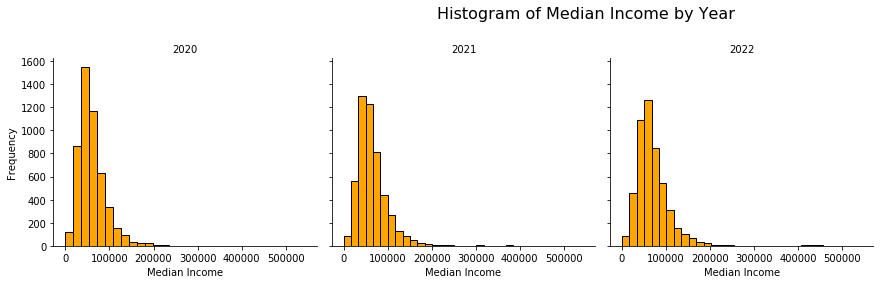

In [68]:
# Create a facet grid with histograms of complete data
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(df_normalized, col='year', col_wrap=4, height=4)
g.map(plt.hist, 'median_income', bins=30, color='orange', edgecolor='black')

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Median Income', 'Frequency')
g.fig.suptitle('Histogram of Median Income by Year', fontsize=16)
g.fig.subplots_adjust(top=0.8)  

plt.show()


In [69]:
# Create a set of unique combinations of geo_id and year
geo_year_combinations = df_missing[['geo_id', 'year']].drop_duplicates()

# Filter merged_df based on these combinations
filtered_merged_df = df_normalized.merge(geo_year_combinations, on=['geo_id', 'year'], how='inner')


In [70]:
#imputed dataframe structure
print(filtered_merged_df.shape)
filtered_merged_df.head()


(716, 24)


,geo_id,median_income,year,block_group,census_tract,county,state,gini_coefficient,est_less_than_10k,est_10to15k,...,est_35to40k,est_40to45k,est_45to50k,est_50to60k,est_60to75k,est_75to100k,est_100to125k,est_125to150k,est_150to200k,est_more_than_200k
0,1500000US290019503003,24998.0,2020,Block Group 3,Census Tract 9503,Adair County,Missouri,0.41,0.49,0.20,...,0.0,0.21,0.00,0.00,0.69,0.22,0.00,0.00,0.00,0.00
1,1500000US290019505021,56830.0,2020,Block Group 1,Census Tract 9505.02,Adair County,Missouri,0.46,0.10,0.08,...,0.0,0.00,0.00,0.16,0.24,0.00,0.32,0.41,0.36,0.19
2,1500000US290099601011,55974.0,2020,Block Group 1,Census Tract 9601.01,Barry County,Missouri,0.40,0.09,0.00,...,0.0,0.27,0.09,0.19,0.00,0.40,0.70,0.00,0.00,0.00
3,1500000US290119603005,48907.0,2020,Block Group 5,Census Tract 9603,Barton County,Missouri,0.37,0.10,0.00,...,0.3,0.00,0.66,0.00,0.00,0.00,0.62,0.23,0.07,0.00
4,1500000US290190003002,11562.0,2020,Block Group 2,Census Tract 3,Boone County,Missouri,0.33,0.90,0.27,...,0.0,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00


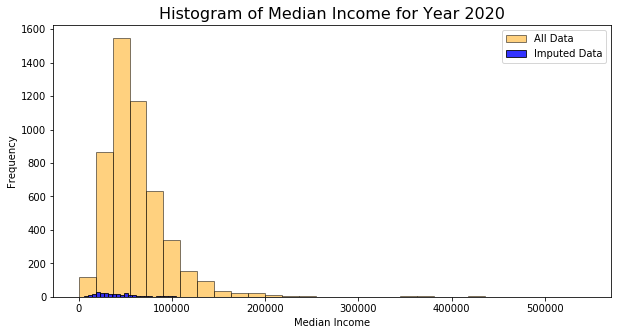

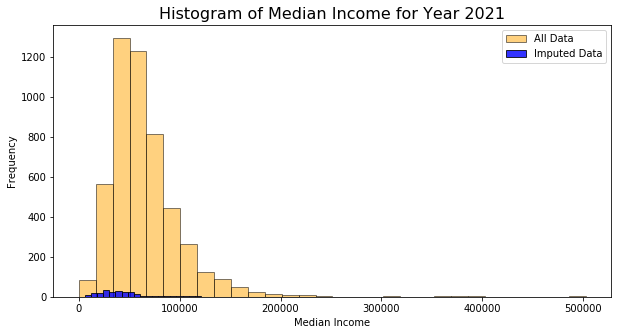

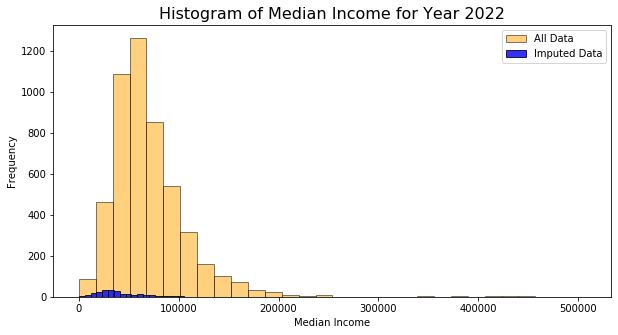

In [71]:
# Get unique years from the df_normalized and use this to plot all data + imputed data
unique_years = df_normalized['year'].unique()

# Create a figure for each year
for year in unique_years:
    plt.figure(figsize=(10, 5))
    
    # Filter the data for the current year
    year_data = df_normalized[df_normalized['year'] == year]
    filtered_year_data = filtered_merged_df[filtered_merged_df['year'] == year]

    # Plot histogram for merged_df with transparency
    plt.hist(year_data['median_income'], bins=30, color='orange', edgecolor='black', alpha=0.5, label='All Data')

    # Plot histogram for filtered_merged_df without transparency
    plt.hist(filtered_year_data['median_income'], bins=30, color='blue', edgecolor='black', alpha=0.8, label='Imputed Data')

    # Set titles and labels
    plt.title(f'Histogram of Median Income for Year {year}', fontsize=16)
    plt.xlabel('Median Income')
    plt.ylabel('Frequency')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [72]:
#get stats for all years
years = df_normalized['year'].unique()

# Get descriptive statistics for each year
for year in years:
    print(f"Descriptive statistics for {year}:")
    print(df_normalized[df_normalized['year'] == year].describe())
    print("\n")

Descriptive statistics for 2020:
       median_income    year  gini_coefficient  est_less_than_10k  \
count    5031.000000  5031.0       5031.000000        5031.000000   
mean    61195.106341  2020.0          0.430654           0.173188   
std     34950.337494     0.0          0.102850           0.198429   
min         0.000000  2020.0         -1.000000           0.000000   
25%     39802.000000  2020.0          0.410000           0.000000   
50%     54231.000000  2020.0          0.440000           0.110000   
75%     74269.500000  2020.0          0.470000           0.260000   
max    544450.000000  2020.0          0.530000           1.000000   

       est_10to15k  est_15to20k  est_20to25k  est_25to30k  est_30to35k  \
count  5031.000000  5031.000000  5031.000000  5031.000000  5031.000000   
mean      0.131461     0.134667     0.143596     0.138627     0.147666   
std       0.163943     0.155869     0.158932     0.154396     0.154422   
min       0.000000     0.000000     0.000000     

In [73]:
#convert year to string
df_filled['year'] = df_filled['year'].astype(str)


In [74]:
#reset index
df_filled2 = df_filled[df_filled['year'].isin(['2020', '2021', '2022'])].reset_index()

In [75]:
#check sample
df_filled2.head()

,index,geo_id,block_group,census_tract,county,state,median_income,year
0,0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,56313.0,2020
1,1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,57167.0,2020
2,2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,48409.0,2020
3,3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,34911.0,2020
4,4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,54141.0,2020


In [76]:
###value of calculating appropriate % change

df_filled2 = df_filled2.sort_values(by=['geo_id', 'year'])

# Calculate percentage changes
df_filled2['pct_change_2020_to_2021'] = df_filled2.groupby('geo_id').apply(
    lambda x: ((x['median_income'].iloc[1] - x['median_income'].iloc[0]) / x['median_income'].iloc[0]) * 100 if len(x) > 1 else None
).reset_index(drop=True)

df_filled2['pct_change_2021_to_2022'] = df_filled2.groupby('geo_id').apply(
    lambda x: ((x['median_income'].iloc[2] - x['median_income'].iloc[1]) / x['median_income'].iloc[1]) * 100 if len(x) > 2 else None
).reset_index(drop=True)

df_filled2['pct_change_2020_to_2022'] = df_filled2.groupby('geo_id').apply(
    lambda x: ((x['median_income'].iloc[2] - x['median_income'].iloc[0]) / x['median_income'].iloc[0]) * 100 if len(x) > 2 else None
).reset_index(drop=True)

# Round the percentage changes
df_filled2['pct_change_2020_to_2021'] = df_filled2['pct_change_2020_to_2021'].round()
df_filled2['pct_change_2021_to_2022'] = df_filled2['pct_change_2021_to_2022'].round()
df_filled2['pct_change_2020_to_2022'] = df_filled2['pct_change_2020_to_2022'].round()

# Create a new DataFrame with the desired output, including Tract and County
result_df = df_filled2.groupby(['geo_id', 'census_tract', 'county']).agg({
    'pct_change_2020_to_2021': 'last',
    'pct_change_2021_to_2022': 'last',
    'pct_change_2020_to_2022': 'last'
}).reset_index()

# Display the final DataFrame
result_df.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


,geo_id,census_tract,county,pct_change_2020_to_2021,pct_change_2021_to_2022,pct_change_2020_to_2022
0,1500000US290019501001,Census Tract 9501,Adair County,26.0,13.0,42.0
1,1500000US290019501002,Census Tract 9501,Adair County,3.0,9.0,12.0
2,1500000US290019501003,Census Tract 9501,Adair County,2.0,6.0,8.0
3,1500000US290019502001,Census Tract 9502,Adair County,3.0,28.0,32.0
4,1500000US290019502002,Census Tract 9502,Adair County,8.0,10.0,18.0


In [77]:
# Get counts of NA values in each column
result_df.isna().sum()

geo_id                      0
census_tract                0
county                      0
pct_change_2020_to_2021    20
pct_change_2021_to_2022    21
pct_change_2020_to_2022    20
dtype: int64

In [78]:
#fill na with 0
result_df.fillna(0, inplace=True)

# Verify that the NA values are filled
result_df.isna().sum()

geo_id                     0
census_tract               0
county                     0
pct_change_2020_to_2021    0
pct_change_2021_to_2022    0
pct_change_2020_to_2022    0
dtype: int64

In [79]:

# create table income_pct_change
try:
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, host=host, password=password)
    cursor = conn.cursor()
    print("Connected to the database.")

    # Drop the income_pct_change table if it exists
    cursor.execute("DROP TABLE IF EXISTS income_pct_change;")
    print("Dropped the income_pct_change table if it existed.")

    # Create the income_pct_change table
    create_table_query = """
CREATE TABLE income_pct_change (
    geo_id TEXT NOT NULL,
    census_tract TEXT NOT NULL,
    county TEXT NOT NULL,
    pct_change_2020_to_2021 INT NOT NULL,
    pct_change_2021_to_2022 INT NOT NULL,
    pct_change_2020_to_2022 INT NOT NULL,
    PRIMARY KEY (geo_id)
);
    """
    cursor.execute(create_table_query)
    conn.commit()
    print("Created the income_pct_change table.")

    # Insert data from result_df in chunks
    chunk_size = 500
    for start in range(0, len(result_df), chunk_size):
        chunk = result_df.iloc[start:start + chunk_size]
        chunk.to_sql('income_pct_change', engine, if_exists='append', index=False)
        print(f"Uploaded a chunk of {len(chunk)} records to the income_pct_change table.")

    print("Data uploaded successfully.")

    # Query the inserted data to confirm
    query = "SELECT * FROM income_pct_change;"
    df = pd.read_sql(query, conn)
    print("Data extracted successfully! DataFrame shape:", df.shape)

except Exception as e:
    print("An error occurred:", e)

finally:
    # Ensure that the cursor and connection are closed
    if cursor:
        cursor.close()
    if conn:
        conn.close()


Connected to the database.
Dropped the income_pct_change table if it existed.
Created the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 500 records to the income_pct_change table.
Uploaded a chunk of 31 records to the income_pct_change table.
Data uploaded successfully.
Data extracted successfully! DataFrame shape: (5031, 6)


In [80]:
#check sample
df.head()

,geo_id,census_tract,county,pct_change_2020_to_2021,pct_change_2021_to_2022,pct_change_2020_to_2022
0,1500000US290019501001,Census Tract 9501,Adair County,26,13,42
1,1500000US290019501002,Census Tract 9501,Adair County,3,9,12
2,1500000US290019501003,Census Tract 9501,Adair County,2,6,8
3,1500000US290019502001,Census Tract 9502,Adair County,3,28,32
4,1500000US290019502002,Census Tract 9502,Adair County,8,10,18


In [81]:
# SQL query to grant privileges

grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE income_pct_change TO jsmm8, remcmf, sgdky;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")
        
# SQL query to grant privileges

grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE income_data_processed TO jsmm8, remcmf, sgdky;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.
Privileges granted successfully.
